In [3]:
import numpy as np
exp = np.exp
arange = np.arange
ln = np.log
from datetime import *

import matplotlib.pyplot as plt
from matplotlib import patches

# import plotly.plotly as py
# import plotly.graph_objs as go

from scipy.stats import norm
from scipy import interpolate as interp
pdf = norm.pdf
cdf = norm.cdf
ppf = norm.ppf

from scipy import stats
from scipy import special
erf = special.erf

import pandas as pd
# import palettable
import seaborn as sns
cp = sns.color_palette()

from lifelines import KaplanMeierFitter
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn import mixture
from sklearn import preprocessing

In [9]:
nsclc = pd.read_csv('nsclc_data.csv')

lc_df = pd.read_csv('lc_data.csv')

In [11]:
def create_kde(array, bandwidth=None):
    """ calculating KDE and CDF using scipy """
    if bandwidth == None:
        bw = 'scott'
    else:
        bw = bandwidth
    kde = stats.gaussian_kde(dataset=array,bw_method=bw)
    
    num_test_points=200
    x = np.linspace(0,np.max(array)*1.2,num_test_points)
    kdens=kde.pdf(x)
    
    cdf=np.zeros(shape=num_test_points)
    for i in range(num_test_points):
        cdf[i] = kde.integrate_box_1d(low=0,high=x[i])
        
    return x,kdens,cdf


def calc_cdf(array,var,bandwidth=None):
    if bandwidth == None:
        bw = 1.2*array.std()*np.power(array.size,-1/5)
    else:
        bw = bandwidth
    kde=stats.gaussian_kde(dataset=array,bw_method=bw)
    return kde.integrate_box_1d(low=0,high=var)




## fig 1

In [12]:
from matplotlib import patches
from matplotlib import path
Path=path.Path

def bracket(xi, y, dy=.1, dx = .04,tail=.1):

    yi = y - dy/2
    xf = xi+dx
    yf = yi+dy
    vertices = [(xi,yi),(xf,yi),(xf,yf),(xi,yf)]+[(xf,y),(xf+tail,y)]
    codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.MOVETO] + [Path.LINETO]
    return Path(vertices,codes)

def hbracket(x, yi, dx=.1, dy = .04,tail=.1):

    xi = x - dx/2
    xf = xi+dx
    yf = yi-dy
    vertices = [(xi,yi),(xi,yf),(xf,yf),(xf,yi)]+[(x,yf),(x,yf-tail)]
    codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.MOVETO] + [Path.LINETO]
    return Path(vertices,codes)

def double_arrow(x,y,length,orient,endlength=.04,r=10):
    l=length
    if orient == 'horz':
        x1= x - l/2
        x2 = x + l/2
        el = endlength/2
        vertices = [(x1,y),(x2,y)]+[(x1+l/r,y+el),(x1,y),(x1+l/r,y-el)]+[(x2-l/r,y+el),(x2,y),(x2-l/r,y-el)]
    else:
        y1= y - l/2
        y2 = y + l/2
        el = endlength/2
        vertices = [(x,y1),(x,y2)]+[(x-el,y1+l/r),(x,y1),(x+el,y1+l/r)]+[(x+el,y2-l/r),(x,y2),(x-el,y2-l/r)]
    codes = [Path.MOVETO,Path.LINETO]+[Path.MOVETO]+[Path.LINETO]*2+[Path.MOVETO]+[Path.LINETO]*2
    return Path(vertices,codes)



In [13]:
div_cmap = sns.light_palette((0,.5,.8),n_colors=20)#as_cmap=True)
#sns.palplot(div_cmap, size = .8)

colors = [(0,.5,.8),(.98,.98,.98),(.7,.1,.1)]
# sns.palplot(sns.blend_palette(colors,n_colors=20))

colmap=sns.blend_palette(colors,as_cmap=True)

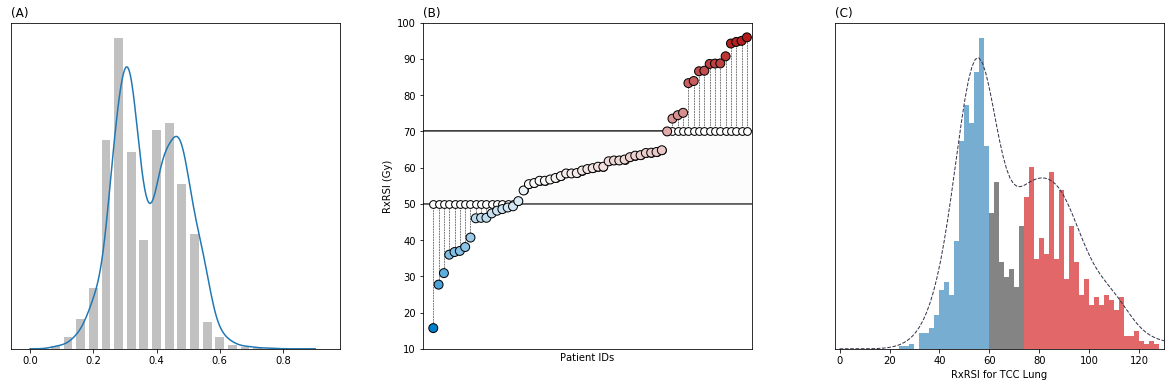

In [8]:

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(18,6))

axes[0].set_title('(A)', loc='left')
axes[1].set_title('(B)', loc='left')
axes[2].set_title('(C)', loc='left')

ax=axes[0]

r = nsclc.rsi
d = 2
beta = 0.05

x, k, c = create_kde(r)
ax.plot(x,k)

bins=np.arange(0,1,.04)
hist = np.histogram(r,bins=bins,density=True)

bar_width = (hist[1][1]-hist[1][0])*.7
ax.bar(hist[1][:-1],hist[0],width=bar_width,alpha=.6,color=(.6,.6,.6))
ax.set_yticks([])

"""-----------------------------------------------------------------------------------------------"""

ax = axes[1]

x = lc_df.new_dose_5070.values
x.sort()
range60 = range(1,61)
x2 = lc_df.new_dose.values
x2.sort()
dose_5070 = lc_df.new_dose_5070.sort_values()
full70 = np.full(len(x),70)

ax.scatter(range60,x2, s = 80, c=x2,cmap=colmap,edgecolors='k',zorder=10) #label = 'RxRSI > 70')
ax.scatter(range60,x,edgecolor = 'k',facecolor='white', marker = 'o', s = 60, zorder = 5, label = 'RxRSI scaled\nto 50-70')

ax.hlines(y = [50,70],xmin = [-2,-2],xmax=[62,62], color = 'k',lw=1.5,zorder=0)
ax.fill_between([-2,62],70,50, color = (.95,.95,.95),alpha=.2)

j = np.where(x2<50)[0][-1]
k = np.where(x2>70)[0][0]
ax.vlines(range60[k:],ymin = full70[k:], ymax = x2[k:], lw = .5, linestyle = '--')
ax.vlines(x = range60[:j], ymin = x2[:j], ymax = np.full(j,50), lw = .5, linestyle = '--')

ax.set_xticklabels('')
ax.set_ylim((10,100))
ax.set_xlim(-1,61)
ax.set_ylabel('RxRSI (Gy)')
ax.set_xlabel('Patient IDs')
ax.set_xticks([])

"""-------------------------------------------------------------------------------"""

ax=axes[2]

r = nsclc.rsi
d = 2
beta = 0.05

# for SF2 alpha
n = 1
alpha_tcc = np.log(r)/(-n*d) - beta*d
rxdose_tcc = 33/(alpha_tcc+beta*d)
rxdose_tcc=rxdose_tcc.values

""" plotting histograms """

binlist=list(np.arange(0,150,2))+[300]

""" <60 range """
xdata = rxdose_tcc[np.where(rxdose_tcc<60)]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.6,#ec = 'k',
        color=cp[0],  
        weights = wts)
""" 60-74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>60)&(rxdose_tcc<74))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.8,#ec = 'k',
        color=(.4,.4,.4),  
        weights = wts,zorder=5)
""" >74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>74))]  #&(rxdose_tcc<80))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.7,#ec = 'k',
        color=cp[3],  
        weights = wts)

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.28)
ax.plot(rxdose_kde[0], rxdose_kde[1] , c=(.2,.2,.3),lw=1,ls='--',label = 'KDE')

ax.set_xlim(-2,130)
ax.set_yticks([])
ax.set_xlabel('RxRSI for TCC Lung')

fig.subplots_adjust(left=.06, right=.95, wspace=.25)
